<a href="https://colab.research.google.com/github/i-ganza007/Kuiper_Summative/blob/main/training/DQN/CNN_seventh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q --force-reinstall "numpy==1.26.4" "scipy<1.13" "scikit-learn<1.6" "matplotlib<3.9"

!apt-get update -qq && apt-get install -y -qq swig cmake libopenmpi-dev zlib1g-dev

!pip install -q \
    "gymnasium[box2d,atari,accept-rom-license]" \
    "stable-baselines3[extra]>=2.0.0" \
    "ale-py" \
    "torch>=2.0" \
    "tensorflow<2.17" \
    "keras<3.0"

!pip cache purge

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback, CheckpointCallback, EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
import json
import time
import os
import torch


2025-11-22 08:25:28.360950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-22 08:25:28.361008: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-22 08:25:28.362762: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
OUTPUT_DIR = "/kaggle/working"
LOG_DIR = f"{OUTPUT_DIR}/logs/mission_env/"
CHECKPOINT_DIR = f"{OUTPUT_DIR}/checkpoints/"
BEST_MODEL_DIR = f"{OUTPUT_DIR}/best_model/"
EVAL_LOG_DIR = f"{OUTPUT_DIR}/eval_logs/"

os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(BEST_MODEL_DIR, exist_ok=True)
os.makedirs(EVAL_LOG_DIR, exist_ok=True)

print("DQN CNN TRAINING - MISSION ENVIRONMENT")
print(f"Output Directory: {OUTPUT_DIR}")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")
if DEVICE == "cuda":
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")


DQN CNN TRAINING - MISSION ENVIRONMENT
Output Directory: /kaggle/working
Device: cuda
GPU Name: Tesla P100-PCIE-16GB
GPU Memory: 15.89 GB


In [ ]:
class MissionEnvironment(gym.Env):
    """Custom Mission Environment with grid-based tasks"""

    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 30}

    def __init__(self, grid_size=10, num_missions=3, render_mode=None):
        super().__init__()
        self.grid_size = grid_size
        self.num_missions = num_missions
        self.render_mode = render_mode

        self.action_space = spaces.Discrete(5)

        obs_size = 4 + (num_missions * 3)
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0] + [0, -grid_size, -grid_size] * num_missions, dtype=np.float32),
            high=np.array([grid_size, grid_size, 200, num_missions] + [np.sqrt(2*grid_size**2), grid_size, grid_size] * num_missions, dtype=np.float32),
            dtype=np.float32
        )

        self.agent_pos = None
        self.missions = None
        self.completed_missions = None
        self.fuel = 200
        self.max_fuel = 200
        self.steps = 0
        self.max_steps = 500
        self.window = None
        self.clock = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.agent_pos = np.array(
            [self.np_random.integers(0, self.grid_size),
             self.np_random.integers(0, self.grid_size)],
            dtype=np.int32
        )
        self.missions = []
        for _ in range(self.num_missions):
            while True:
                mission = np.array(
                    [self.np_random.integers(0, self.grid_size),
                     self.np_random.integers(0, self.grid_size)],
                    dtype=np.int32
                )
                if not np.array_equal(mission, self.agent_pos) and \
                   not any(np.array_equal(mission, m) for m in self.missions):
                    self.missions.append(mission)
                    break
        self.completed_missions = np.zeros(self.num_missions, dtype=bool)
        self.fuel = self.max_fuel
        self.steps = 0
        return self._get_observation(), {}

    def _get_observation(self):
        obs = np.zeros(4 + self.num_missions * 3, dtype=np.float32)
        obs[0] = float(self.agent_pos[0])
        obs[1] = float(self.agent_pos[1])
        obs[2] = float(self.fuel)
        obs[3] = float(np.sum(self.completed_missions))

        mission_idx = 0
        for i in range(self.num_missions):
            if not self.completed_missions[i]:
                dx = float(self.missions[i][0] - self.agent_pos[0])
                dy = float(self.missions[i][1] - self.agent_pos[1])
                dist = np.sqrt(dx**2 + dy**2)
                obs[4 + mission_idx*3] = dist
                obs[4 + mission_idx*3 + 1] = dx
                obs[4 + mission_idx*3 + 2] = dy
            else:
                obs[4 + mission_idx*3] = 0.0
                obs[4 + mission_idx*3 + 1] = 0.0
                obs[4 + mission_idx*3 + 2] = 0.0
            mission_idx += 1

        return obs

    def step(self, action):
        self.steps += 1
        reward = -0.1
        terminated = False
        truncated = self.steps >= self.max_steps

        if action < 4:
            if self.fuel > 0:
                deltas = [(-1, 0), (1, 0), (0, -1), (0, 1)][action]
                new_pos = self.agent_pos + np.array(deltas, dtype=np.int32)

                if 0 <= new_pos[0] < self.grid_size and 0 <= new_pos[1] < self.grid_size:
                    self.agent_pos = new_pos
                    self.fuel -= 1

                    active_mission_indices = [i for i in range(self.num_missions)
                                            if not self.completed_missions[i]]
                    if active_mission_indices:
                        distances = [np.linalg.norm(self.agent_pos.astype(float) - self.missions[i].astype(float))
                                   for i in active_mission_indices]
                        min_dist = np.min(distances)
                        reward += 2.0 / (1.0 + min_dist)
                else:
                    reward -= 0.2
            else:
                reward -= 0.1

        elif action == 4:
            mission_completed = False
            for i, mission in enumerate(self.missions):
                if not self.completed_missions[i] and np.array_equal(self.agent_pos, mission):
                    self.completed_missions[i] = True
                    reward += 200.0
                    mission_completed = True
                    self.fuel = min(self.max_fuel, self.fuel + 30)
                    break

            if not mission_completed:
                reward -= 0.5

        completed_count = np.sum(self.completed_missions)
        if completed_count == self.num_missions:
            reward += 500.0
            reward += self.fuel * 0.5
            terminated = True

        if self.fuel <= 0 and not terminated:
            reward -= 10.0
            terminated = True

        if truncated and not terminated:
            reward -= 5.0

        return self._get_observation(), reward, terminated, truncated, {}

    def render(self):
        if self.render_mode is None:
            return
        if self.window is None and self.render_mode == "human":
            import pygame
            pygame.init()
            self.window = pygame.display.set_mode((600, 600))
            self.clock = pygame.time.Clock()

        import pygame
        canvas = pygame.Surface((600, 600))
        canvas.fill((255, 255, 255))
        pix = 600 / self.grid_size

        for i, m in enumerate(self.missions):
            color = (100, 200, 100) if self.completed_missions[i] else (200, 100, 100)
            pygame.draw.rect(canvas, color, (m[0]*pix, m[1]*pix, pix, pix))

        pygame.draw.circle(canvas, (0, 0, 255),
                          ((self.agent_pos[0]+0.5)*pix, (self.agent_pos[1]+0.5)*pix),
                          pix/3)

        for x in range(self.grid_size + 1):
            pygame.draw.line(canvas, (200, 200, 200), (x*pix, 0), (x*pix, 600))
            pygame.draw.line(canvas, (200, 200, 200), (0, x*pix), (600, x*pix))

        if self.render_mode == "human":
            self.window.blit(canvas, (0, 0))
            pygame.display.flip()
            self.clock.tick(30)

    def close(self):
        if self.window:
            import pygame
            pygame.quit()
            self.window = None

# Register the environment
gym.register(id="MissionEnv-v0", entry_point="__main__:MissionEnvironment", max_episode_steps=500)
print("✓ MissionEnvironment registered!\n")

✓ MissionEnvironment registered!



In [ ]:
CONFIG = {
    "lr": 0.001,
    "gamma": 0.80,
    "batch": 12,
    "eps_start": 1.0,
    "eps_end": 0.4,
    "eps_decay": 0.2,
    "buffer_size": 50_000,
    "learning_starts": 5_000,
    "target_update": 10_000,
    "total_steps": 200_000
}


print("Configuration:")
for key, val in CONFIG.items():
    print(f"  {key}: {val}")
print()

Configuration:
  lr: 0.001
  gamma: 0.8
  batch: 12
  eps_start: 1.0
  eps_end: 0.4
  eps_decay: 0.2
  buffer_size: 50000
  learning_starts: 5000
  target_update: 10000
  total_steps: 200000



In [ ]:
class GridToImageWrapper(gym.ObservationWrapper):
    """Convert grid-based observations to images for CNN processing"""

    def __init__(self, env, img_size=84):
        super().__init__(env)
        self.img_size = img_size
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(img_size, img_size, 1), dtype=np.uint8
        )

    def observation(self, obs):
        """Convert vector observation to image"""
        img = np.zeros((self.img_size, self.img_size, 1), dtype=np.uint8)

        # Unwrap to get base environment
        base_env = self.env
        while hasattr(base_env, 'env'):
            base_env = base_env.env

        agent_x = int((obs[0] / base_env.grid_size) * (self.img_size - 1))
        agent_y = int((obs[1] / base_env.grid_size) * (self.img_size - 1))

        img[max(0, agent_y-2):min(self.img_size, agent_y+3),
            max(0, agent_x-2):min(self.img_size, agent_x+3), 0] = 255

        for i in range(base_env.num_missions):
            mission_x = int((base_env.missions[i][0] / base_env.grid_size) * (self.img_size - 1))
            mission_y = int((base_env.missions[i][1] / base_env.grid_size) * (self.img_size - 1))

            if not base_env.completed_missions[i]:
                img[max(0, mission_y-1):min(self.img_size, mission_y+2),
                    max(0, mission_x-1):min(self.img_size, mission_x+2), 0] = 150
            else:
                img[max(0, mission_y-1):min(self.img_size, mission_y+2),
                    max(0, mission_x-1):min(self.img_size, mission_x+2), 0] = 100

        fuel_pct = int((obs[2] / 200) * 20)
        img[0:5, 0:fuel_pct, 0] = 200

        return img

class DetailedMetricsCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_successes = []
        self.timesteps = []
        self.exploration_rates = []

    def _on_step(self) -> bool:
        if any(self.locals["dones"]):
            for i, done in enumerate(self.locals["dones"]):
                if done and "episode" in self.locals["infos"][i]:
                    info = self.locals["infos"][i]["episode"]
                    self.ep_rewards.append(info["r"])
                    self.ep_lengths.append(info["l"])
                    self.timesteps.append(self.num_timesteps)
                    success = 1 if info["r"] >= 500 else 0
                    self.ep_successes.append(success)

        if hasattr(self.model, 'exploration_rate'):
            self.exploration_rates.append(self.model.exploration_rate)

        return True

print(" Wrapper and Callbacks defined!\n")

 Wrapper and Callbacks defined!



In [ ]:
print("Creating environment...")
env = gym.make("MissionEnv-v0")
env = GridToImageWrapper(env, img_size=84)
env = Monitor(env, LOG_DIR)

eval_env = gym.make("MissionEnv-v0")
eval_env = GridToImageWrapper(eval_env, img_size=84)
eval_env = Monitor(eval_env, EVAL_LOG_DIR)

print(f" Observation Space: {env.observation_space}")
print(f" Action Space: {env.action_space}\n")

Creating environment...
 Observation Space: Box(0, 255, (84, 84, 1), uint8)
 Action Space: Discrete(5)



In [ ]:
print("Creating DQN model with CnnPolicy...")
model = DQN(
    "CnnPolicy",
    env,
    learning_rate=CONFIG["lr"],
    gamma=CONFIG["gamma"],
    batch_size=CONFIG["batch"],
    buffer_size=CONFIG["buffer_size"],
    learning_starts=CONFIG["learning_starts"],
    exploration_initial_eps=CONFIG["eps_start"],
    exploration_final_eps=CONFIG["eps_end"],
    exploration_fraction=CONFIG["eps_decay"],
    target_update_interval=CONFIG["target_update"],
    train_freq=4,
    gradient_steps=1,
    tensorboard_log=LOG_DIR,
    verbose=1,
    device=DEVICE
)

print("✓ Model created successfully!")
print(f"  Buffer size: {model.buffer_size:,}")
print(f"  Learning starts: {model.learning_starts:,} steps")
print(f"  Policy: CnnPolicy (CNN)")

if DEVICE == "cuda":
    print(f"  Initial GPU memory: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
print()

Creating DQN model with CnnPolicy...
Using cuda device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
✓ Model created successfully!
  Buffer size: 50,000
  Learning starts: 5,000 steps
  Policy: CnnPolicy (CNN)
  Initial GPU memory: 0.23 GB



In [ ]:
print("Setting up callbacks...")
checkpoint_cb = CheckpointCallback(
    save_freq=50_000,
    save_path=CHECKPOINT_DIR,
    name_prefix="dqn_mission",
    save_replay_buffer=False
)

eval_cb = EvalCallback(
    eval_env,
    best_model_save_path=BEST_MODEL_DIR,
    log_path=EVAL_LOG_DIR,
    eval_freq=10_000,
    n_eval_episodes=10,
    deterministic=True,
    render=False
)

metrics_cb = DetailedMetricsCallback()
callback_list = [checkpoint_cb, eval_cb, metrics_cb]

print(" Callbacks configured!\n")

Setting up callbacks...
 Callbacks configured!



In [ ]:

print("="*70)
print("STARTING TRAINING")
print("="*70)
print(f"Total Timesteps: {CONFIG['total_steps']:,}\n")

start_time = time.time()

try:
    model.learn(
        total_timesteps=CONFIG["total_steps"],
        tb_log_name="DQN_MissionEnv_CnnPolicy",
        log_interval=50,
        progress_bar=True,
        callback=callback_list
    )

    train_time = time.time() - start_time
    print("\n" + "="*70)
    print("TRAINING COMPLETED SUCCESSFULLY!")
    print("="*70)

    if DEVICE == "cuda":
        print(f"Max GPU memory used: {torch.cuda.max_memory_allocated()/1024**3:.2f} GB")
    print(f"Training time: {train_time:.2f} seconds ({train_time/60:.2f} minutes)\n")

except RuntimeError as e:
    if "out of memory" in str(e).lower():
        print("\n" + "!"*70)
        print("OUT OF MEMORY ERROR")
        print("!"*70)
        print("Try these fixes:")
        print("  1. Reduce buffer_size: 50000 → 25000")
        print("  2. Reduce batch_size: 32 → 16")
        print("  3. Use device='cpu'")
        print("  4. Reduce total_steps in CONFIG")
    raise e

STARTING TRAINING
Total Timesteps: 200,000

Logging to /kaggle/working/logs/mission_env/DQN_MissionEnv_CnnPolicy_7


Output()

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x7c7dd43efd50> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7c7dd4306b90>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=10000, episode_reward=83.35 +/- 28.66

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 83.3     |
| rollout/            |          |
|    exploration_rate | 0.85     |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00547  |
|    n_updates        | 1249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 290      |
|    ep_rew_mean      | 214      |
|    exploration_rate | 0.783    |
| time/               |          |
|    episodes         | 50       |
|    fps              | 822      |
|    time_elapsed     | 17       |
|    total_timesteps  | 14475    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0116   |
|    n_updates        | 2368     |
----------------------------------


Eval num_timesteps=20000, episode_reward=124.86 +/- 35.99

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 125      |
| rollout/            |          |
|    exploration_rate | 0.7      |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0259   |
|    n_updates        | 3749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 276      |
|    ep_rew_mean      | 200      |
|    exploration_rate | 0.586    |
| time/               |          |
|    episodes         | 100      |
|    fps              | 661      |
|    time_elapsed     | 41       |
|    total_timesteps  | 27630    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.024    |
|    n_updates        | 5657     |
----------------------------------


Eval num_timesteps=30000, episode_reward=139.55 +/- 79.07

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 140      |
| rollout/            |          |
|    exploration_rate | 0.55     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.831    |
|    n_updates        | 6249     |
----------------------------------


New best mean reward!

Eval num_timesteps=40000, episode_reward=204.79 +/- 101.35

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 205      |
| rollout/            |          |
|    exploration_rate | 0.4      |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0156   |
|    n_updates        | 8749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 269      |
|    ep_rew_mean      | 302      |
|    exploration_rate | 0.4      |
| time/               |          |
|    episodes         | 150      |
|    fps              | 574      |
|    time_elapsed     | 72       |
|    total_timesteps  | 41362    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.046    |
|    n_updates        | 9090     |
----------------------------------


Eval num_timesteps=50000, episode_reward=185.79 +/- 79.55

Episode length: 200.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | 186      |
| rollout/            |          |
|    exploration_rate | 0.4      |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0554   |
|    n_updates        | 11249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 261      |
|    ep_rew_mean      | 495      |
|    exploration_rate | 0.4      |
| time/               |          |
|    episodes         | 200      |
|    fps              | 545      |
|    time_elapsed     | 98       |
|    total_timesteps  | 53757    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.1      |
|    n_updates        | 12189    |
----------------------------------


Eval num_timesteps=60000, episode_reward=228.59 +/- 101.40

Episode length: 230.00 +/- 90.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 230      |
|    mean_reward      | 229      |
| rollout/            |          |
|    exploration_rate | 0.4      |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0371   |
|    n_updates        | 13749    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 232      |
|    ep_rew_mean      | 696      |
|    exploration_rate | 0.4      |
| time/               |          |
|    episodes         | 250      |
|    fps              | 530      |
|    time_elapsed     | 121      |
|    total_timesteps  | 64565    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0625   |
|    n_updates        | 14891    |
----------------------------------


Eval num_timesteps=70000, episode_reward=343.53 +/- 330.82

Episode length: 244.50 +/- 139.38

----------------------------------
| eval/               |          |
|    mean_ep_length   | 244      |
|    mean_reward      | 344      |
| rollout/            |          |
|    exploration_rate | 0.4      |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0718   |
|    n_updates        | 16249    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 177      |
|    ep_rew_mean      | 942      |
|    exploration_rate | 0.4      |
| time/               |          |
|    episodes         | 300      |
|    fps              | 518      |
|    time_elapsed     | 137      |
|    total_timesteps  | 71477    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.212    |
|    n_updates        | 16619    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 151      |
|    ep_rew_mean      | 1.05e+03 |
|    exploration_rate | 0.4      |
| time/               |          |
|    episodes         | 350      |
|    fps              | 518      |
|    time_elapsed     | 153      |
|    total_timesteps  | 79704    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.15     |
|    n_updates      

Eval num_timesteps=80000, episode_reward=448.16 +/- 394.85

Episode length: 173.00 +/- 74.43

----------------------------------
| eval/               |          |
|    mean_ep_length   | 173      |
|    mean_reward      | 448      |
| rollout/            |          |
|    exploration_rate | 0.4      |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 56.9     |
|    n_updates        | 18749    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 178      |
|    ep_rew_mean      | 980      |
|    exploration_rate | 0.4      |
| time/               |          |
|    episodes         | 400      |
|    fps              | 514      |
|    time_elapsed     | 173      |
|    total_timesteps  | 89303    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0879   |
|    n_updates        | 21075    |
----------------------------------


Eval num_timesteps=90000, episode_reward=247.61 +/- 356.11

Episode length: 248.50 +/- 139.02

----------------------------------
| eval/               |          |
|    mean_ep_length   | 248      |
|    mean_reward      | 248      |
| rollout/            |          |
|    exploration_rate | 0.4      |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.09     |
|    n_updates        | 21249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 181      |
|    ep_rew_mean      | 946      |
|    exploration_rate | 0.4      |
| time/               |          |
|    episodes         | 450      |
|    fps              | 508      |
|    time_elapsed     | 192      |
|    total_timesteps  | 97782    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.101    |
|    n_updates        | 23195    |
----------------------------------


Eval num_timesteps=100000, episode_reward=371.16 +/- 313.49

Episode length: 186.80 +/- 58.13

----------------------------------
| eval/               |          |
|    mean_ep_length   | 187      |
|    mean_reward      | 371      |
| rollout/            |          |
|    exploration_rate | 0.4      |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.85     |
|    n_updates        | 23749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 166      |
|    ep_rew_mean      | 981      |
|    exploration_rate | 0.4      |
| time/               |          |
|    episodes         | 500      |
|    fps              | 504      |
|    time_elapsed     | 209      |
|    total_timesteps  | 105936   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 5.33     |
|    n_updates        | 25233    |
----------------------------------


Eval num_timesteps=110000, episode_reward=87.77 +/- 232.56

Episode length: 382.40 +/- 144.03

----------------------------------
| eval/               |          |
|    mean_ep_length   | 382      |
|    mean_reward      | 87.8     |
| rollout/            |          |
|    exploration_rate | 0.4      |
| time/               |          |
|    total_timesteps  | 110000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0323   |
|    n_updates        | 26249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 166      |
|    ep_rew_mean      | 983      |
|    exploration_rate | 0.4      |
| time/               |          |
|    episodes         | 550      |
|    fps              | 497      |
|    time_elapsed     | 229      |
|    total_timesteps  | 114351   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 5.3      |
|    n_updates        | 27337    |
----------------------------------


Eval num_timesteps=120000, episode_reward=323.91 +/- 136.64

Episode length: 239.00 +/- 87.51

----------------------------------
| eval/               |          |
|    mean_ep_length   | 239      |
|    mean_reward      | 324      |
| rollout/            |          |
|    exploration_rate | 0.4      |
| time/               |          |
|    total_timesteps  | 120000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.915    |
|    n_updates        | 28749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 161      |
|    ep_rew_mean      | 990      |
|    exploration_rate | 0.4      |
| time/               |          |
|    episodes         | 600      |
|    fps              | 493      |
|    time_elapsed     | 247      |
|    total_timesteps  | 122015   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 3.61     |
|    n_updates        | 29253    |
----------------------------------
--------------------

Eval num_timesteps=130000, episode_reward=423.07 +/- 408.00

Episode length: 208.10 +/- 113.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 208      |
|    mean_reward      | 423      |
| rollout/            |          |
|    exploration_rate | 0.4      |
| time/               |          |
|    total_timesteps  | 130000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.22     |
|    n_updates        | 31249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 106      |
|    ep_rew_mean      | 1.14e+03 |
|    exploration_rate | 0.4      |
| time/               |          |
|    episodes         | 700      |
|    fps              | 492      |
|    time_elapsed     | 269      |
|    total_timesteps  | 132611   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 14.7     |
|    n_updates        | 31902    |
----------------------------------
--------------------

Eval num_timesteps=140000, episode_reward=366.03 +/- 569.51

Episode length: 355.20 +/- 221.20

----------------------------------
| eval/               |          |
|    mean_ep_length   | 355      |
|    mean_reward      | 366      |
| rollout/            |          |
|    exploration_rate | 0.4      |
| time/               |          |
|    total_timesteps  | 140000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 6.64     |
|    n_updates        | 33749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 109      |
|    ep_rew_mean      | 1.14e+03 |
|    exploration_rate | 0.4      |
| time/               |          |
|    episodes         | 800      |
|    fps              | 488      |
|    time_elapsed     | 293      |
|    total_timesteps  | 143552   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 9.06     |
|    n_updates        | 34637    |
----------------------------------
--------------------

Eval num_timesteps=150000, episode_reward=304.80 +/- 494.70

Episode length: 344.60 +/- 199.61

----------------------------------
| eval/               |          |
|    mean_ep_length   | 345      |
|    mean_reward      | 305      |
| rollout/            |          |
|    exploration_rate | 0.4      |
| time/               |          |
|    total_timesteps  | 150000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 9.42     |
|    n_updates        | 36249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 136      |
|    ep_rew_mean      | 1.07e+03 |
|    exploration_rate | 0.4      |
| time/               |          |
|    episodes         | 900      |
|    fps              | 486      |
|    time_elapsed     | 322      |
|    total_timesteps  | 157179   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 9.61     |
|    n_updates        | 38044    |
----------------------------------


Eval num_timesteps=160000, episode_reward=-64.80 +/- 287.70

----------------------------------
| eval/               |          |
|    mean_ep_length   | 381      |
|    mean_reward      | -64.8    |
| rollout/            |          |
|    exploration_rate | 0.4      |
| time/               |          |
|    total_timesteps  | 160000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 7.35     |
|    n_updates        | 38749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 134      |
|    ep_rew_mean      | 1.09e+03 |
|    exploration_rate | 0.4      |
| time/               |          |
|    episodes         | 950      |
|    fps              | 481      |
|    time_elapsed     | 338      |
|    total_timesteps  | 163223   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 13.7     |
|    n_updates        | 39555    |
----------------------------------
--------------------

Eval num_timesteps=170000, episode_reward=142.47 +/- 560.18

Episode length: 343.70 +/- 199.86

----------------------------------
| eval/               |          |
|    mean_ep_length   | 344      |
|    mean_reward      | 142      |
| rollout/            |          |
|    exploration_rate | 0.4      |
| time/               |          |
|    total_timesteps  | 170000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 7.1      |
|    n_updates        | 41249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | 1.16e+03 |
|    exploration_rate | 0.4      |
| time/               |          |
|    episodes         | 1050     |
|    fps              | 479      |
|    time_elapsed     | 361      |
|    total_timesteps  | 173401   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 4.05     |
|    n_updates        | 42100    |
----------------------------------
--------------------

Eval num_timesteps=180000, episode_reward=333.56 +/- 599.65

Episode length: 327.80 +/- 216.23

----------------------------------
| eval/               |          |
|    mean_ep_length   | 328      |
|    mean_reward      | 334      |
| rollout/            |          |
|    exploration_rate | 0.4      |
| time/               |          |
|    total_timesteps  | 180000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 7.64     |
|    n_updates        | 43749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 83.5     |
|    ep_rew_mean      | 1.2e+03  |
|    exploration_rate | 0.4      |
| time/               |          |
|    episodes         | 1150     |
|    fps              | 476      |
|    time_elapsed     | 381      |
|    total_timesteps  | 181754   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 8.24     |
|    n_updates        | 44188    |
----------------------------------
--------------------

Eval num_timesteps=190000, episode_reward=580.32 +/- 557.02

Episode length: 249.70 +/- 215.92

----------------------------------
| eval/               |          |
|    mean_ep_length   | 250      |
|    mean_reward      | 580      |
| rollout/            |          |
|    exploration_rate | 0.4      |
| time/               |          |
|    total_timesteps  | 190000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 10.3     |
|    n_updates        | 46249    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 87.5     |
|    ep_rew_mean      | 1.17e+03 |
|    exploration_rate | 0.4      |
| time/               |          |
|    episodes         | 1250     |
|    fps              | 474      |
|    time_elapsed     | 401      |
|    total_timesteps  | 190503   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 13.1     |
|    n_updates        | 46375    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 96.5     |
|    ep_rew_mean      | 1.15e+03 |
|    exploration_rate | 0.4      |
| time/               |          |
|    episodes         | 1300     |
|    fps              | 475      |
|    time_elapsed     | 410      |
|    total_timesteps  | 194946   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 23.9     |
|    n_updates      

Eval num_timesteps=200000, episode_reward=485.57 +/- 627.07

Episode length: 218.80 +/- 199.33

----------------------------------
| eval/               |          |
|    mean_ep_length   | 219      |
|    mean_reward      | 486      |
| rollout/            |          |
|    exploration_rate | 0.4      |
| time/               |          |
|    total_timesteps  | 200000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 25       |
|    n_updates        | 48749    |
----------------------------------



TRAINING COMPLETED SUCCESSFULLY!
Max GPU memory used: 0.26 GB
Training time: 422.60 seconds (7.04 minutes)



In [ ]:
print("Evaluating model on 50 episodes...")

eval_env_test = gym.make("MissionEnv-v0")
eval_env_test = GridToImageWrapper(eval_env_test, img_size=84)

mean_reward, std_reward = evaluate_policy(
    model, eval_env_test, n_eval_episodes=50, deterministic=True
)

eval_env_test.close()

print(f"Mean Reward: {mean_reward:.2f} ± {std_reward:.2f}\n")

Evaluating model on 50 episodes...
Mean Reward: 589.53 ± 587.07



In [ ]:
model_path = f"{OUTPUT_DIR}/dqn_cnn_mission_seventh_config.zip"
model.save(model_path)
print(f" Model saved: {model_path}")

results = {
    "model": "DQN-CnnPolicy",
    "total_timesteps": CONFIG["total_steps"],
    "training_time_sec": train_time,
    "mean_reward": float(mean_reward),
    "std_reward": float(std_reward),
    "avg_episode_length": float(np.mean(metrics_cb.ep_lengths[-20:])),
    "success_rate": float((np.sum(metrics_cb.ep_successes) / len(metrics_cb.ep_successes)) * 100) if len(metrics_cb.ep_successes) > 0 else 0,
    "hyperparameters": CONFIG,
    "device": DEVICE
}

results_path = f"{OUTPUT_DIR}/dqn_results.json"
with open(results_path, "w") as f:
    json.dump(results, f, indent=4)
print(f"Results saved: {results_path}\n")

 Model saved: /kaggle/working/dqn_cnn_mission_seventh_config.zip
Results saved: /kaggle/working/dqn_results.json



 Saved visualization: /kaggle/working/dqn_training_results.png


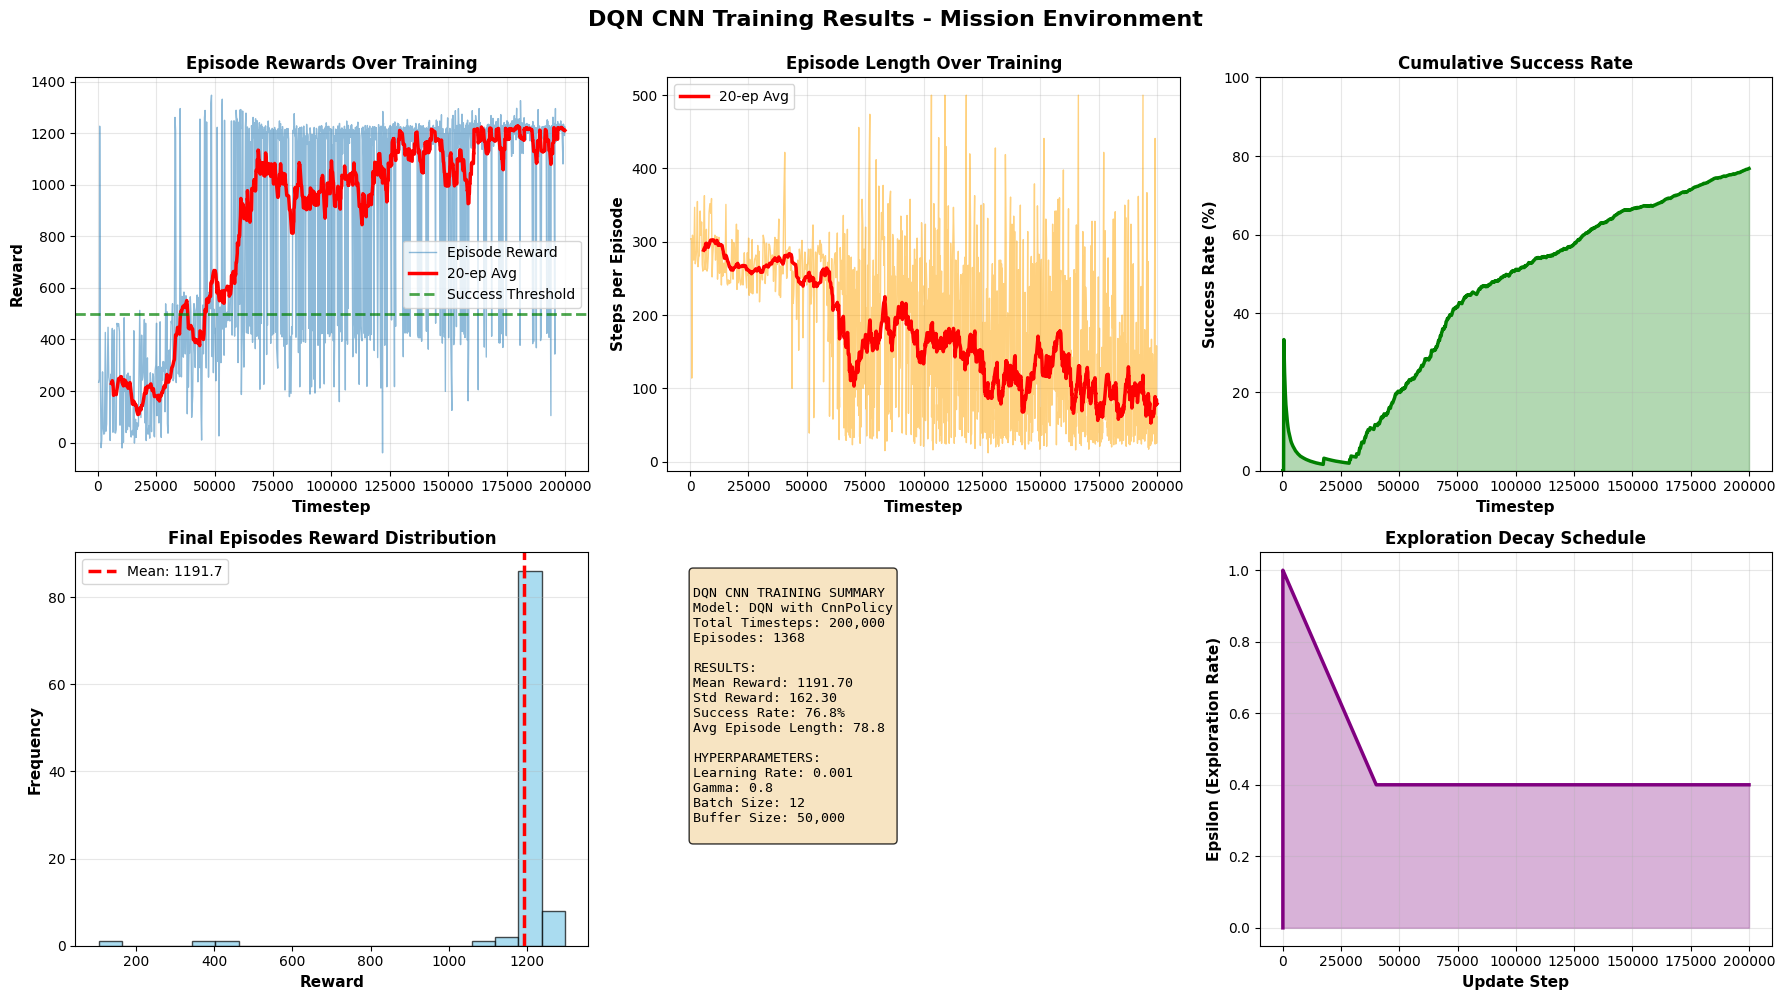

In [ ]:
rewards = np.array(metrics_cb.ep_rewards)
lengths = np.array(metrics_cb.ep_lengths)
successes = np.array(metrics_cb.ep_successes)
timesteps = np.array(metrics_cb.timesteps)

fig = plt.figure(figsize=(18, 10))
fig.suptitle('DQN CNN Training Results - Mission Environment',
             fontsize=16, fontweight='bold', y=0.995)

ax1 = plt.subplot(2, 3, 1)
ax1.plot(timesteps, rewards, alpha=0.5, label='Episode Reward', linewidth=1)
if len(rewards) > 20:
    rolling = np.convolve(rewards, np.ones(20)/20, mode='valid')
    ax1.plot(timesteps[19:], rolling, linewidth=2.5, label='20-ep Avg', color='red')
ax1.axhline(y=500, color='g', linestyle='--', linewidth=2, alpha=0.7, label='Success Threshold')
ax1.set_xlabel('Timestep', fontsize=11, fontweight='bold')
ax1.set_ylabel('Reward', fontsize=11, fontweight='bold')
ax1.set_title('Episode Rewards Over Training', fontsize=12, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(2, 3, 2)
ax2.plot(timesteps, lengths, alpha=0.5, color='orange', linewidth=1)
if len(lengths) > 20:
    rolling_len = np.convolve(lengths, np.ones(20)/20, mode='valid')
    ax2.plot(timesteps[19:], rolling_len, linewidth=2.5, color='red', label='20-ep Avg')
ax2.set_xlabel('Timestep', fontsize=11, fontweight='bold')
ax2.set_ylabel('Steps per Episode', fontsize=11, fontweight='bold')
ax2.set_title('Episode Length Over Training', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = plt.subplot(2, 3, 3)
cum_success = np.cumsum(successes)
success_pct = (cum_success / np.arange(1, len(cum_success)+1)) * 100
ax3.plot(timesteps, success_pct, linewidth=2.5, color='green')
ax3.fill_between(timesteps, 0, success_pct, alpha=0.3, color='green')
ax3.set_xlabel('Timestep', fontsize=11, fontweight='bold')
ax3.set_ylabel('Success Rate (%)', fontsize=11, fontweight='bold')
ax3.set_title('Cumulative Success Rate', fontsize=12, fontweight='bold')
ax3.set_ylim([0, 100])
ax3.grid(True, alpha=0.3)

ax4 = plt.subplot(2, 3, 4)
final_rewards = rewards[-min(100, len(rewards)):]
ax4.hist(final_rewards, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
ax4.axvline(np.mean(final_rewards), color='red', linestyle='--', linewidth=2.5,
           label=f'Mean: {np.mean(final_rewards):.1f}')
ax4.set_xlabel('Reward', fontsize=11, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax4.set_title('Final Episodes Reward Distribution', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

ax5 = plt.subplot(2, 3, 5)
ax5.axis('off')

final_success_rate = (np.sum(successes) / len(successes) * 100) if len(successes) > 0 else 0

summary_text = f"""
DQN CNN TRAINING SUMMARY
Model: DQN with CnnPolicy
Total Timesteps: {CONFIG['total_steps']:,}
Episodes: {len(rewards)}

RESULTS:
Mean Reward: {np.mean(final_rewards):.2f}
Std Reward: {np.std(final_rewards):.2f}
Success Rate: {final_success_rate:.1f}%
Avg Episode Length: {np.mean(lengths[-20:]):.1f}

HYPERPARAMETERS:
Learning Rate: {CONFIG['lr']}
Gamma: {CONFIG['gamma']}
Batch Size: {CONFIG['batch']}
Buffer Size: {CONFIG['buffer_size']:,}
"""

ax5.text(0.05, 0.95, summary_text, fontsize=9.5, family='monospace',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax6 = plt.subplot(2, 3, 6)
if len(metrics_cb.exploration_rates) > 0:
    ax6.plot(metrics_cb.exploration_rates, linewidth=2.5, color='purple')
    ax6.fill_between(range(len(metrics_cb.exploration_rates)), metrics_cb.exploration_rates, alpha=0.3, color='purple')
    ax6.set_xlabel('Update Step', fontsize=11, fontweight='bold')
    ax6.set_ylabel('Epsilon (Exploration Rate)', fontsize=11, fontweight='bold')
    ax6.set_title('Exploration Decay Schedule', fontsize=12, fontweight='bold')
    ax6.grid(True, alpha=0.3)

plt.tight_layout()

output_path = f"{OUTPUT_DIR}/dqn_training_results.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f" Saved visualization: {output_path}")
plt.show()

In [ ]:
env.close()
eval_env.close()

print("ALL TRAINING COMPLETE!")
print(f"Outputs saved to: {OUTPUT_DIR}")
print("\nFiles created:")
print(f"  • {model_path}")
print(f"  • {results_path}")
print(f"  • {output_path}")
print(f"  • {CHECKPOINT_DIR}")
print(f"  • {BEST_MODEL_DIR}")
